In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob

In [43]:
#data_path = set your own path to data dir
data_path = 'C:/Users/alon/Repose/robotics_kinova_lab/Lab4/data_lab4'
real_path = []
for file in glob.glob(data_path + '/*/*.pkl'):
    with open(file, 'rb') as h:
        real_path.append(pickle.load(h))

In [44]:
def plot_xyz(Key_points, r_path, p_path, num, flag):

    fig = plt.figure(figsize = (55,20))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.scatter(Key_points[:,0],Key_points[:,1], Key_points[:,2], c='red', s=10) 
    ax1.plot(r_path[:,0], r_path[:,1], r_path[:,2], color='black')
    if flag == 0:
        ax1.plot(p_path[:,0], p_path[:,1], p_path[:,2], color='blue')
        ax1.legend(['Real path','Planned path', 'Key points'])
    else:
        ax1.legend(['Real path', 'Key points'])
    ax1.set_xlabel('X[m]')
    ax1.set_ylabel('Y[m]')
    ax1.set_zlabel('Z[m]')
    ax1.set_title(f"XYZ Gripper path, {num}")

    plt.savefig(f"C:/Users/alon/Repose/robotics_kinova_lab/Lab4/figs/{num}.png")

    plt.show()

def plot_angles(path_ang, num):

    s_1 = np.linspace(0, len(path_ang[:,0]), num=len(path_ang[:,0])) # 2HZ sampling
    t_1 = s_1/2
    fig1 = plt.figure(figsize = (45,15))
    ax2 = fig1.add_subplot(4, 4, 1)
    ax2.plot(t_1, path_ang[:,0], color='black')
    ax2.plot(t_1, path_ang[:,1], color='blue')
    ax2.plot(t_1, path_ang[:,2], color='green')
    ax2.plot(t_1, path_ang[:,3], color='red')
    ax2.plot(t_1, path_ang[:,4], color='yellow')
    ax2.plot(t_1, path_ang[:,5], color='brown')
    ax2.set_xlabel('time[sec]')
    ax2.set_ylabel('Angle[deg]')
    ax2.set_title(f"Joints Angles path {num}")
    ax2.legend(['Joint_1','Joint_2','Joint_3','Joint_4','Joint_5','Joint_6'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [45]:
def traj_gen_config(q1, q2, t, Tf):
    """    
    B.C: q(0) = q1; q_dot(0) = 0; q(Tf) = q2; q_dot(Tf) = 0; 
    """
    a0 = q1
    a1 = 0.
    a2 = (3 / (Tf ** 2)) * (q2 - q1)
    a3 = (2 / (Tf ** 3)) * (q1 - q2)
    q = a0 + a1 * t + a2 * (t ** 2) + a3 * (t ** 3)
    dq = a1 + 2 * a2 * t + 3 * a3 * (t ** 2)
    ddq = 2 * a2 + 6 * a3 * t
    
    '''
    linear: a0 = q1 ; a1 = (q2 - q1) / Tf ; q = a0 + a1 * t ; dq = a1 ; ddq = 0;
    '''
    return q, dq, ddq

def traj_gen_task(x_s, x_g, t, Tf):
    a0 = x_s
    a1 = 0.
    a2 = (3 / (Tf ** 2)) * (x_g - x_s)
    a3 = (2 / (Tf ** 3)) * (x_s - x_g)
    x = a0 + a1 * t + a2 * (t ** 2) + a3 * (t ** 3)
    dx = a1 + 2 * a2 * t + 3 * a3 * (t ** 2)
    ddx = 2 * a2 + 6 * a3 * t
    return x, dx, ddx
    
def traj_gen_task_L(x_s, x_g, t, Tf):
    a0 = x_s
    a1 = (x_g - x_s) / Tf 
    x = a0 + a1 * t
    dx = a1
    ddx = 0
    return x, dx, ddx

In [46]:
### rec 1 
x_1 = np.array([[0.415, 0.335, 0.615, 90.4, 0.1, 166],
                [0.445, -0.057, 0.281, 169.759, 0.238, 95.399],
                [0.434, -0.049, 0.006, 175.89, 0.755, 93.778],
                [0.467, -0.224, 0.159, 81.521, -0.95, 108.473]])

jointPoses_1 = np.array([[22.41, 319.858, 358.647, 329.983, 291.341, 57.045],
                        [0.962, 325.185, 45.99, 270.511, 271.036, 85.574],
                        [2.779, 304.625, 76.142, 269.026, 315.635, 89.646],
                        [308.182, 290.667, 68.802, 20.536, 276.567, 310.149]])

### rec 2
x_2 = np.array([[0.44, 0.187, 0.419, 96, 1, 150],
                [0.463, -0.131, 0.298, 99.211, -175.981, 99.796],
                [0.634, -0.14, 0.297, 87.317, -177.205, 92.726],
                [0.305, 0.403, 0.53, 105.716, -159.563, 171.653]])

jointPoses_2 = np.array([[0.1, 343, 75, 354, 300, 0.1],
                        [334.71, 325.18, 122.117, 234.212, 80.389, 279.347],
                        [347.508, 311.931, 77.55, 243.598, 35.784, 288.416],
                        [37.575, 340.48, 90.23, 211.41, 59.793, 304.981]])               

In [47]:
Tf = 3
N = 5
t = np.linspace(0, Tf, N)
planned_path_1 = []
planned_path_1_L = []
planned_path_2 = []


# Desired path 1 (TS)
for i in range(3):  
    for t1 in t:
        x1, dx1, ddx1 = traj_gen_task(x_1[i,:], x_1[i + 1,:], t1, Tf)
        planned_path_1.append(x1)
        x1L, dx1L, ddx1L = traj_gen_task_L(x_1[i,:], x_1[i + 1,:], t1, Tf)
        planned_path_1_L.append(x1L)
planned_path_1 = np.array(planned_path_1)
planned_path_1_L = np.array(planned_path_1_L)



# Desired path 2 (TS)
for j in range(3):  
    for t2 in t:
        x2, dx2, ddx2 = traj_gen_task(x_2[j,:], x_2[j + 1,:], t2, Tf)
        planned_path_2.append(x2)
planned_path_2 = np.array(planned_path_2)


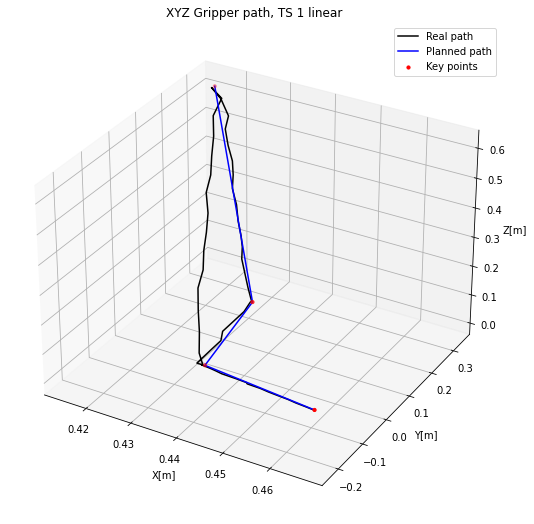

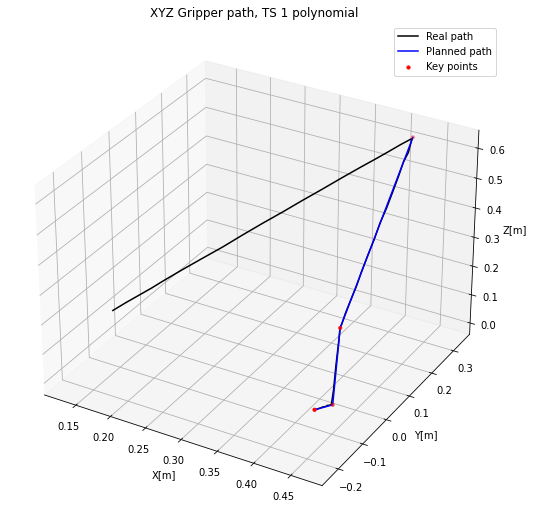

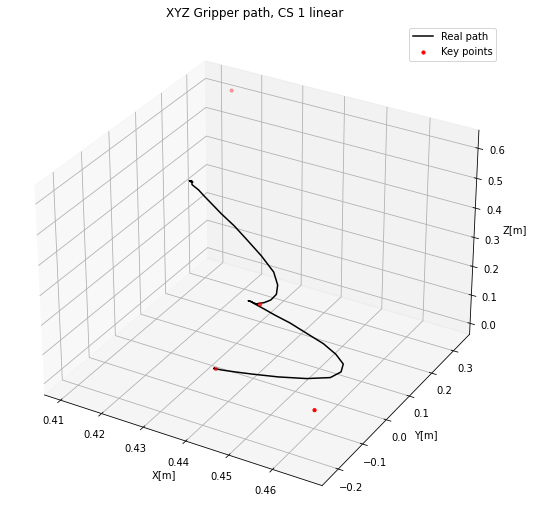

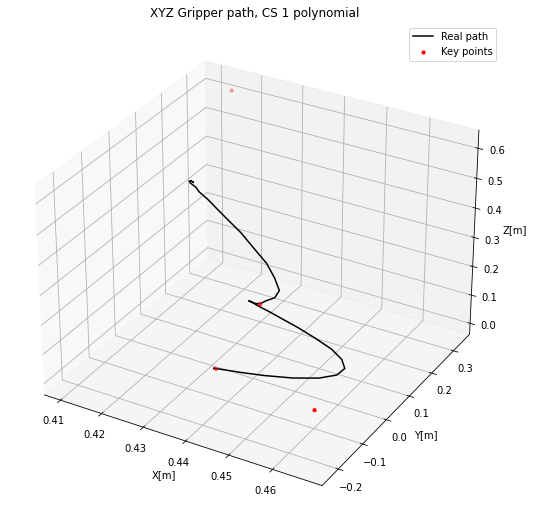

In [48]:
# Path 1

# TS_1 real Linear 
plot_xyz(x_1, real_path[3][1], planned_path_1_L, 'TS 1 linear', 0)

# TS_1 real polynomial 
plot_xyz(x_1, real_path[4][1], planned_path_1, 'TS 1 polynomial', 0)

# # CS_1 real Linear 
plot_xyz(x_1, real_path[0][1], [], 'CS 1 linear', 1) # stack before point 3

# # CS_1 real Linear 
plot_xyz(x_1, real_path[1][1], [], 'CS 1 polynomial', 1) # stack before point 3


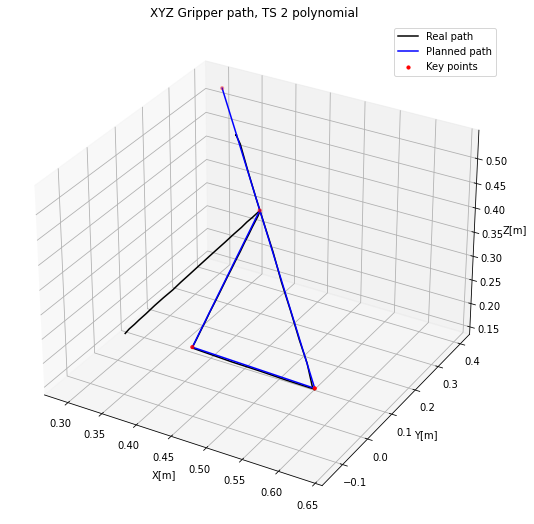

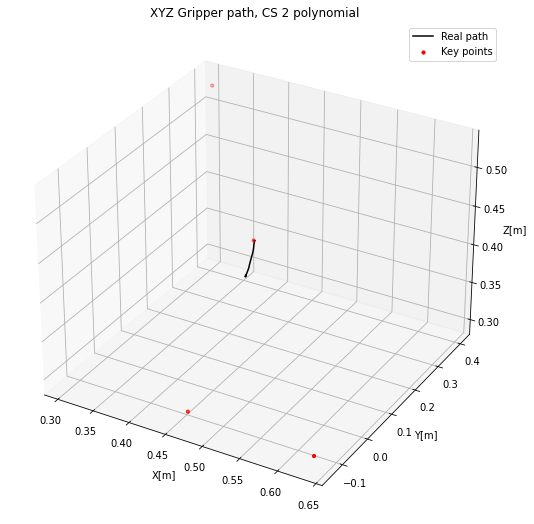

In [49]:
# Path 2

# TS_2 real polynomial 
plot_xyz(x_2, real_path[5][1], planned_path_2, 'TS 2 polynomial', 0)

# CS_2 real polynomial 
plot_xyz(x_2, real_path[2][1], [], 'CS 2 polynomial', 1)
